In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})
import tqdm
import copy

C:\Users\d.dovgopolyi\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=False, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

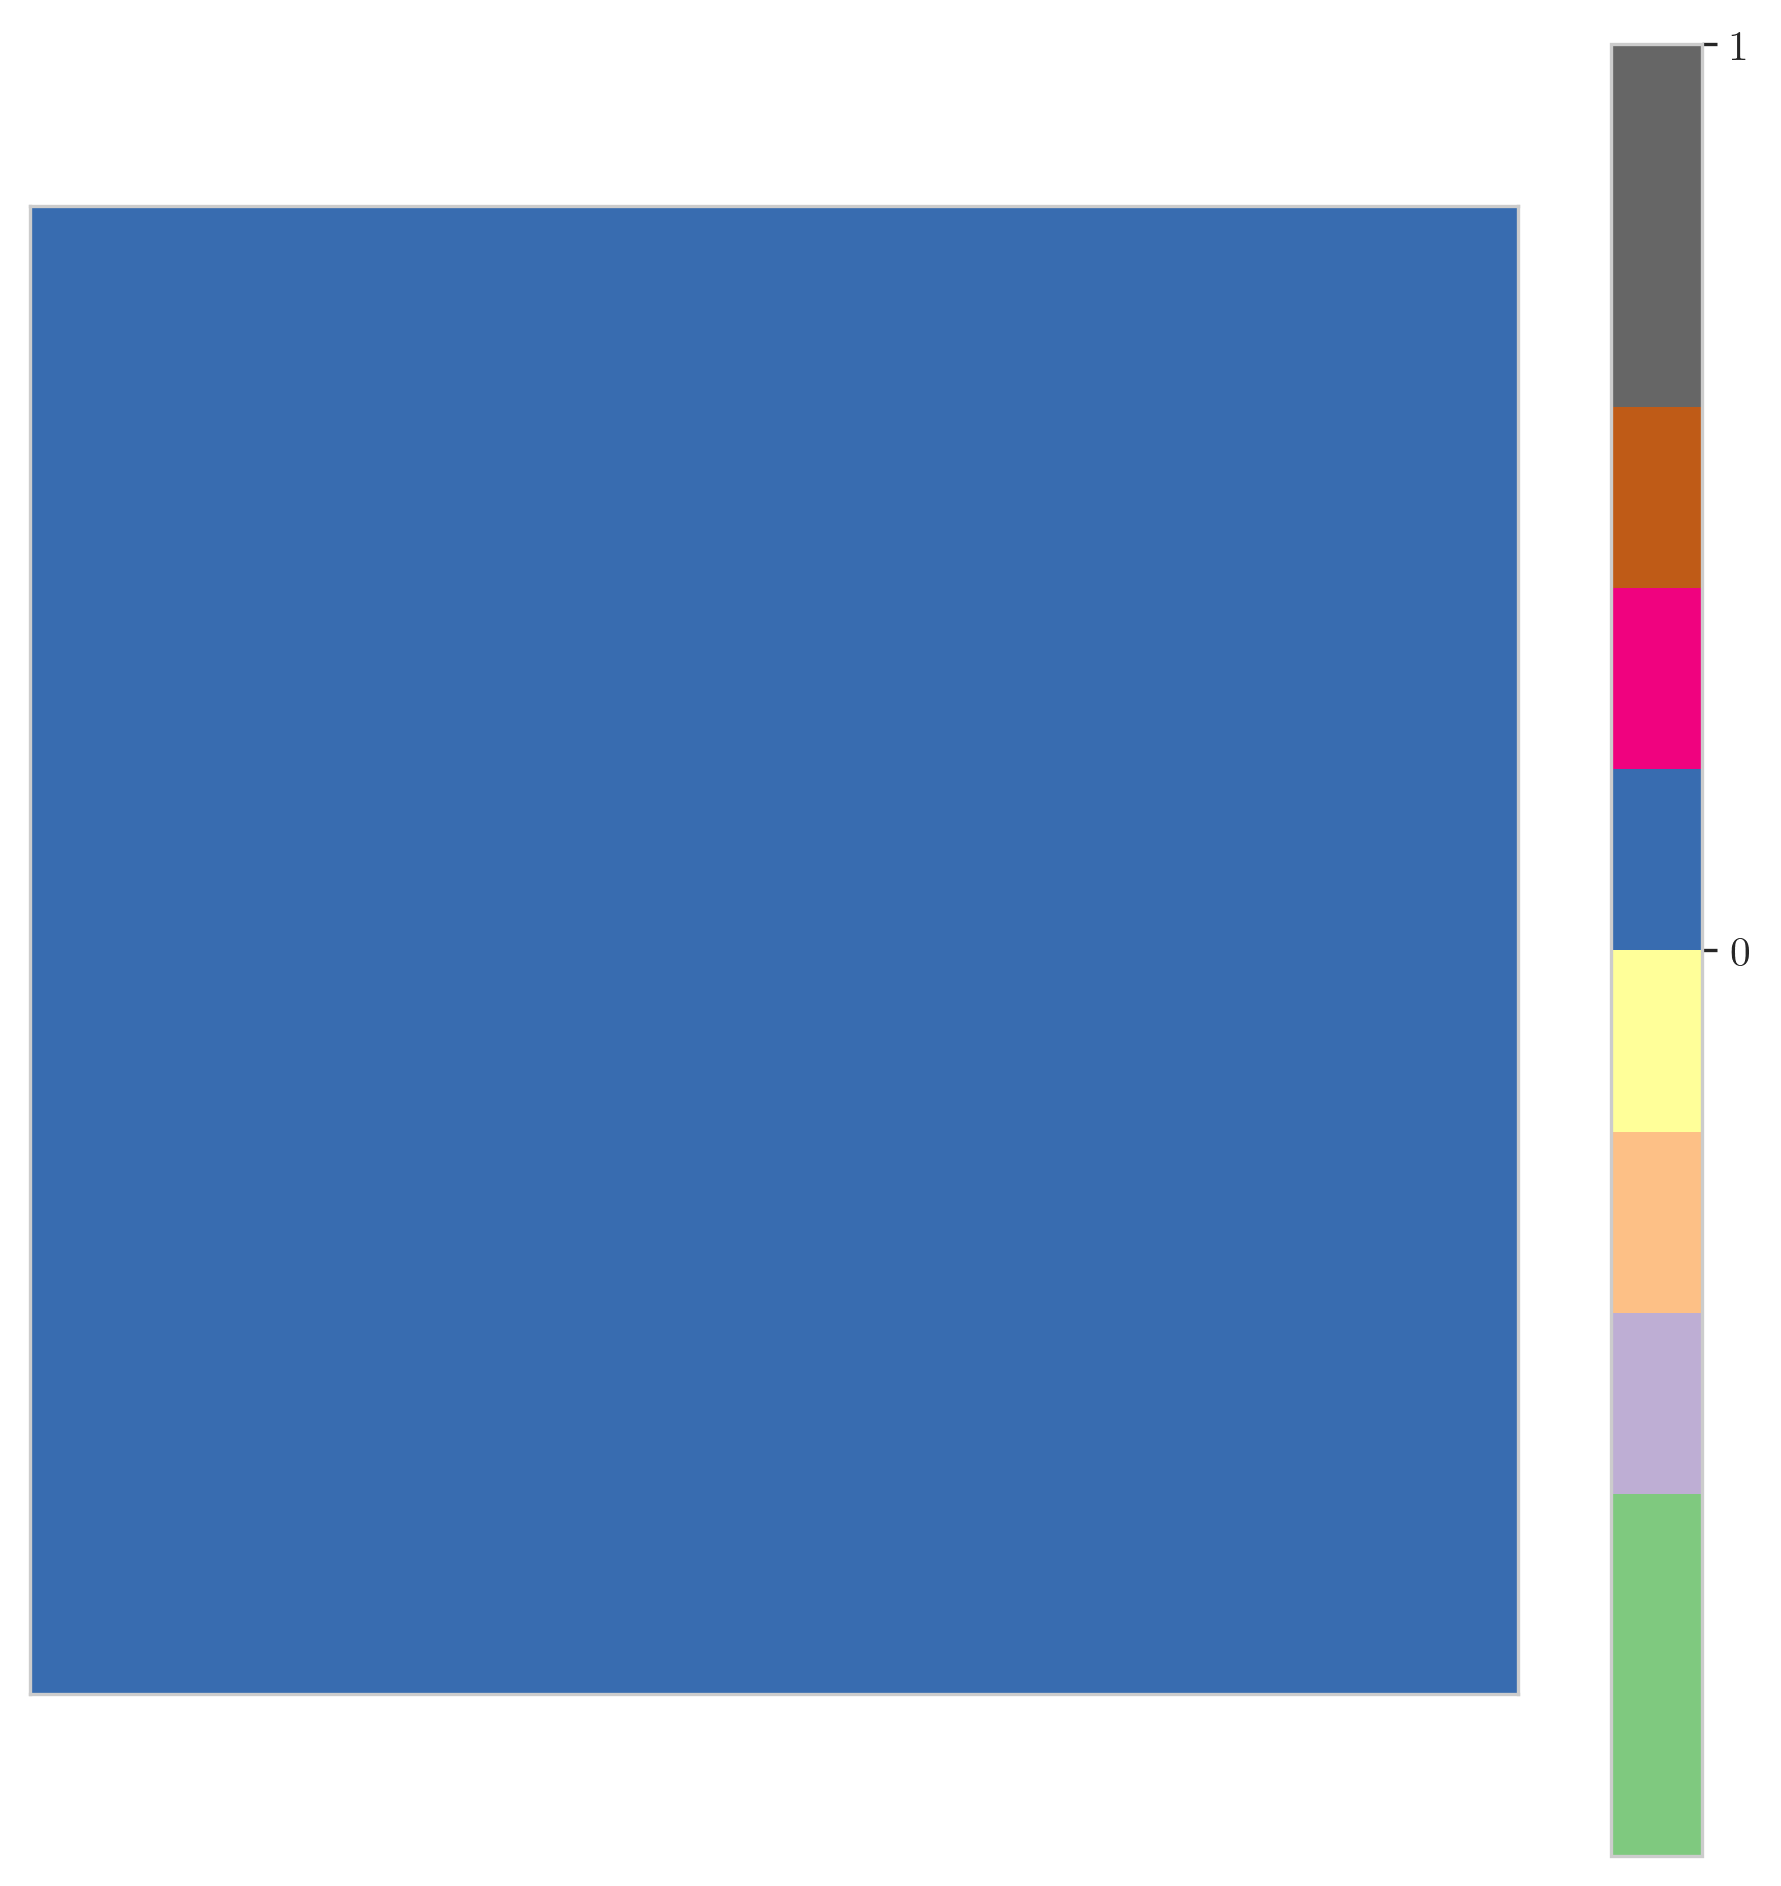

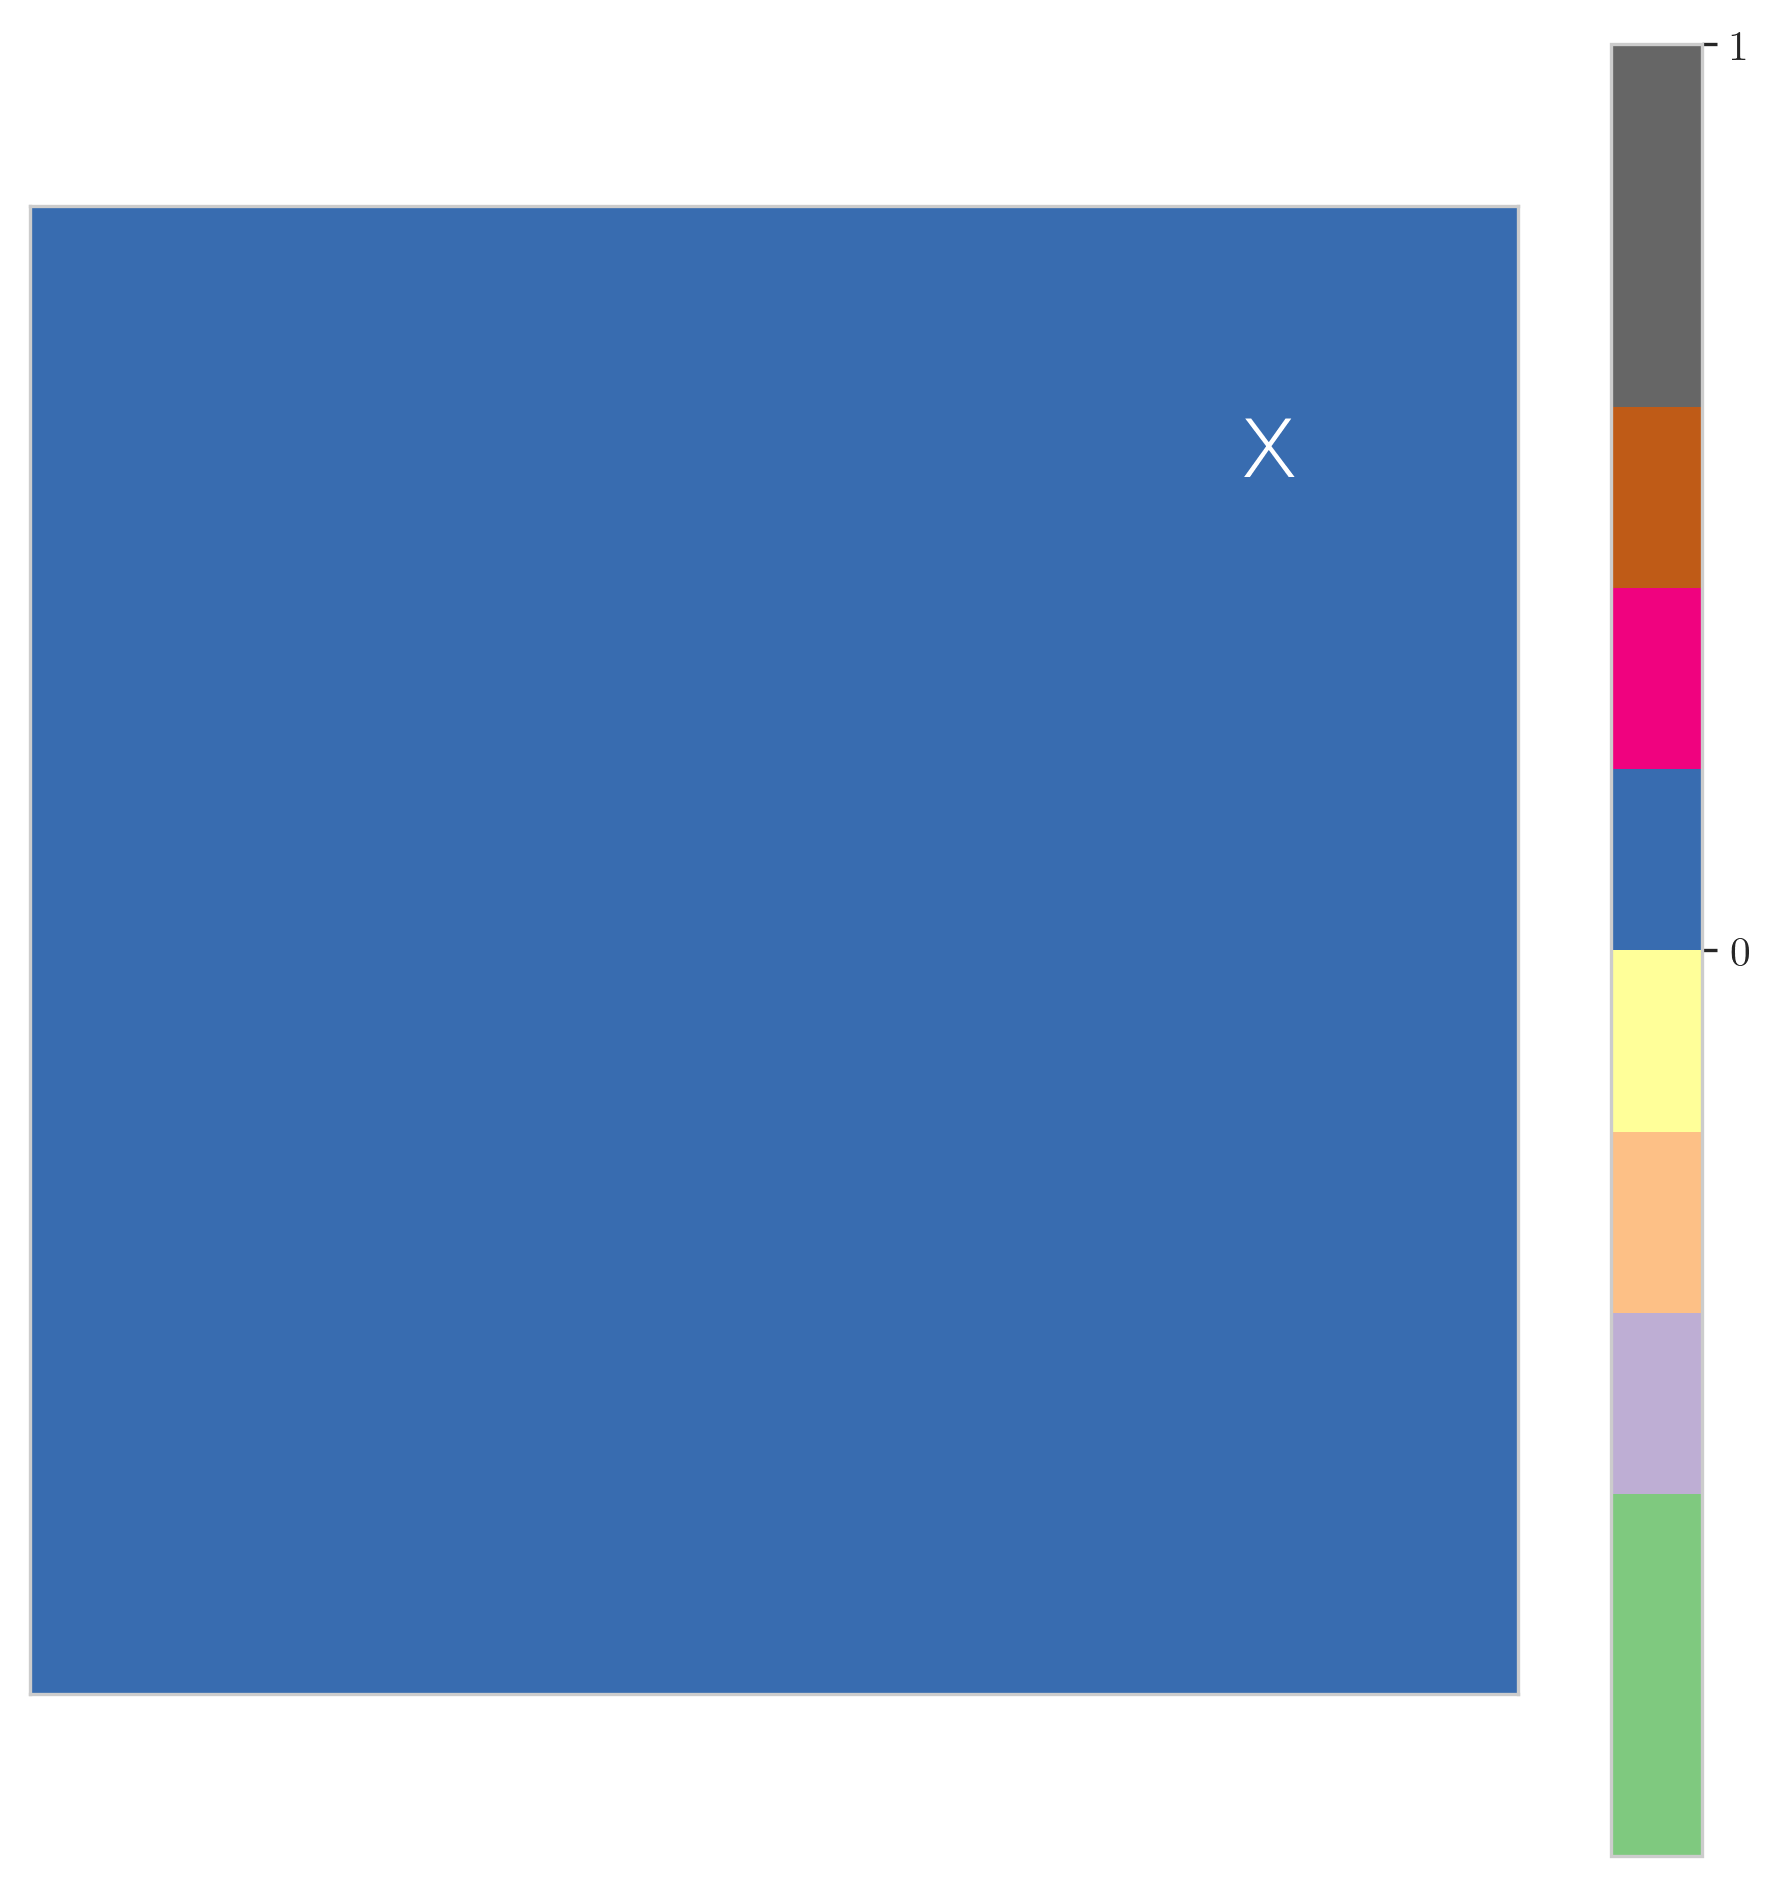

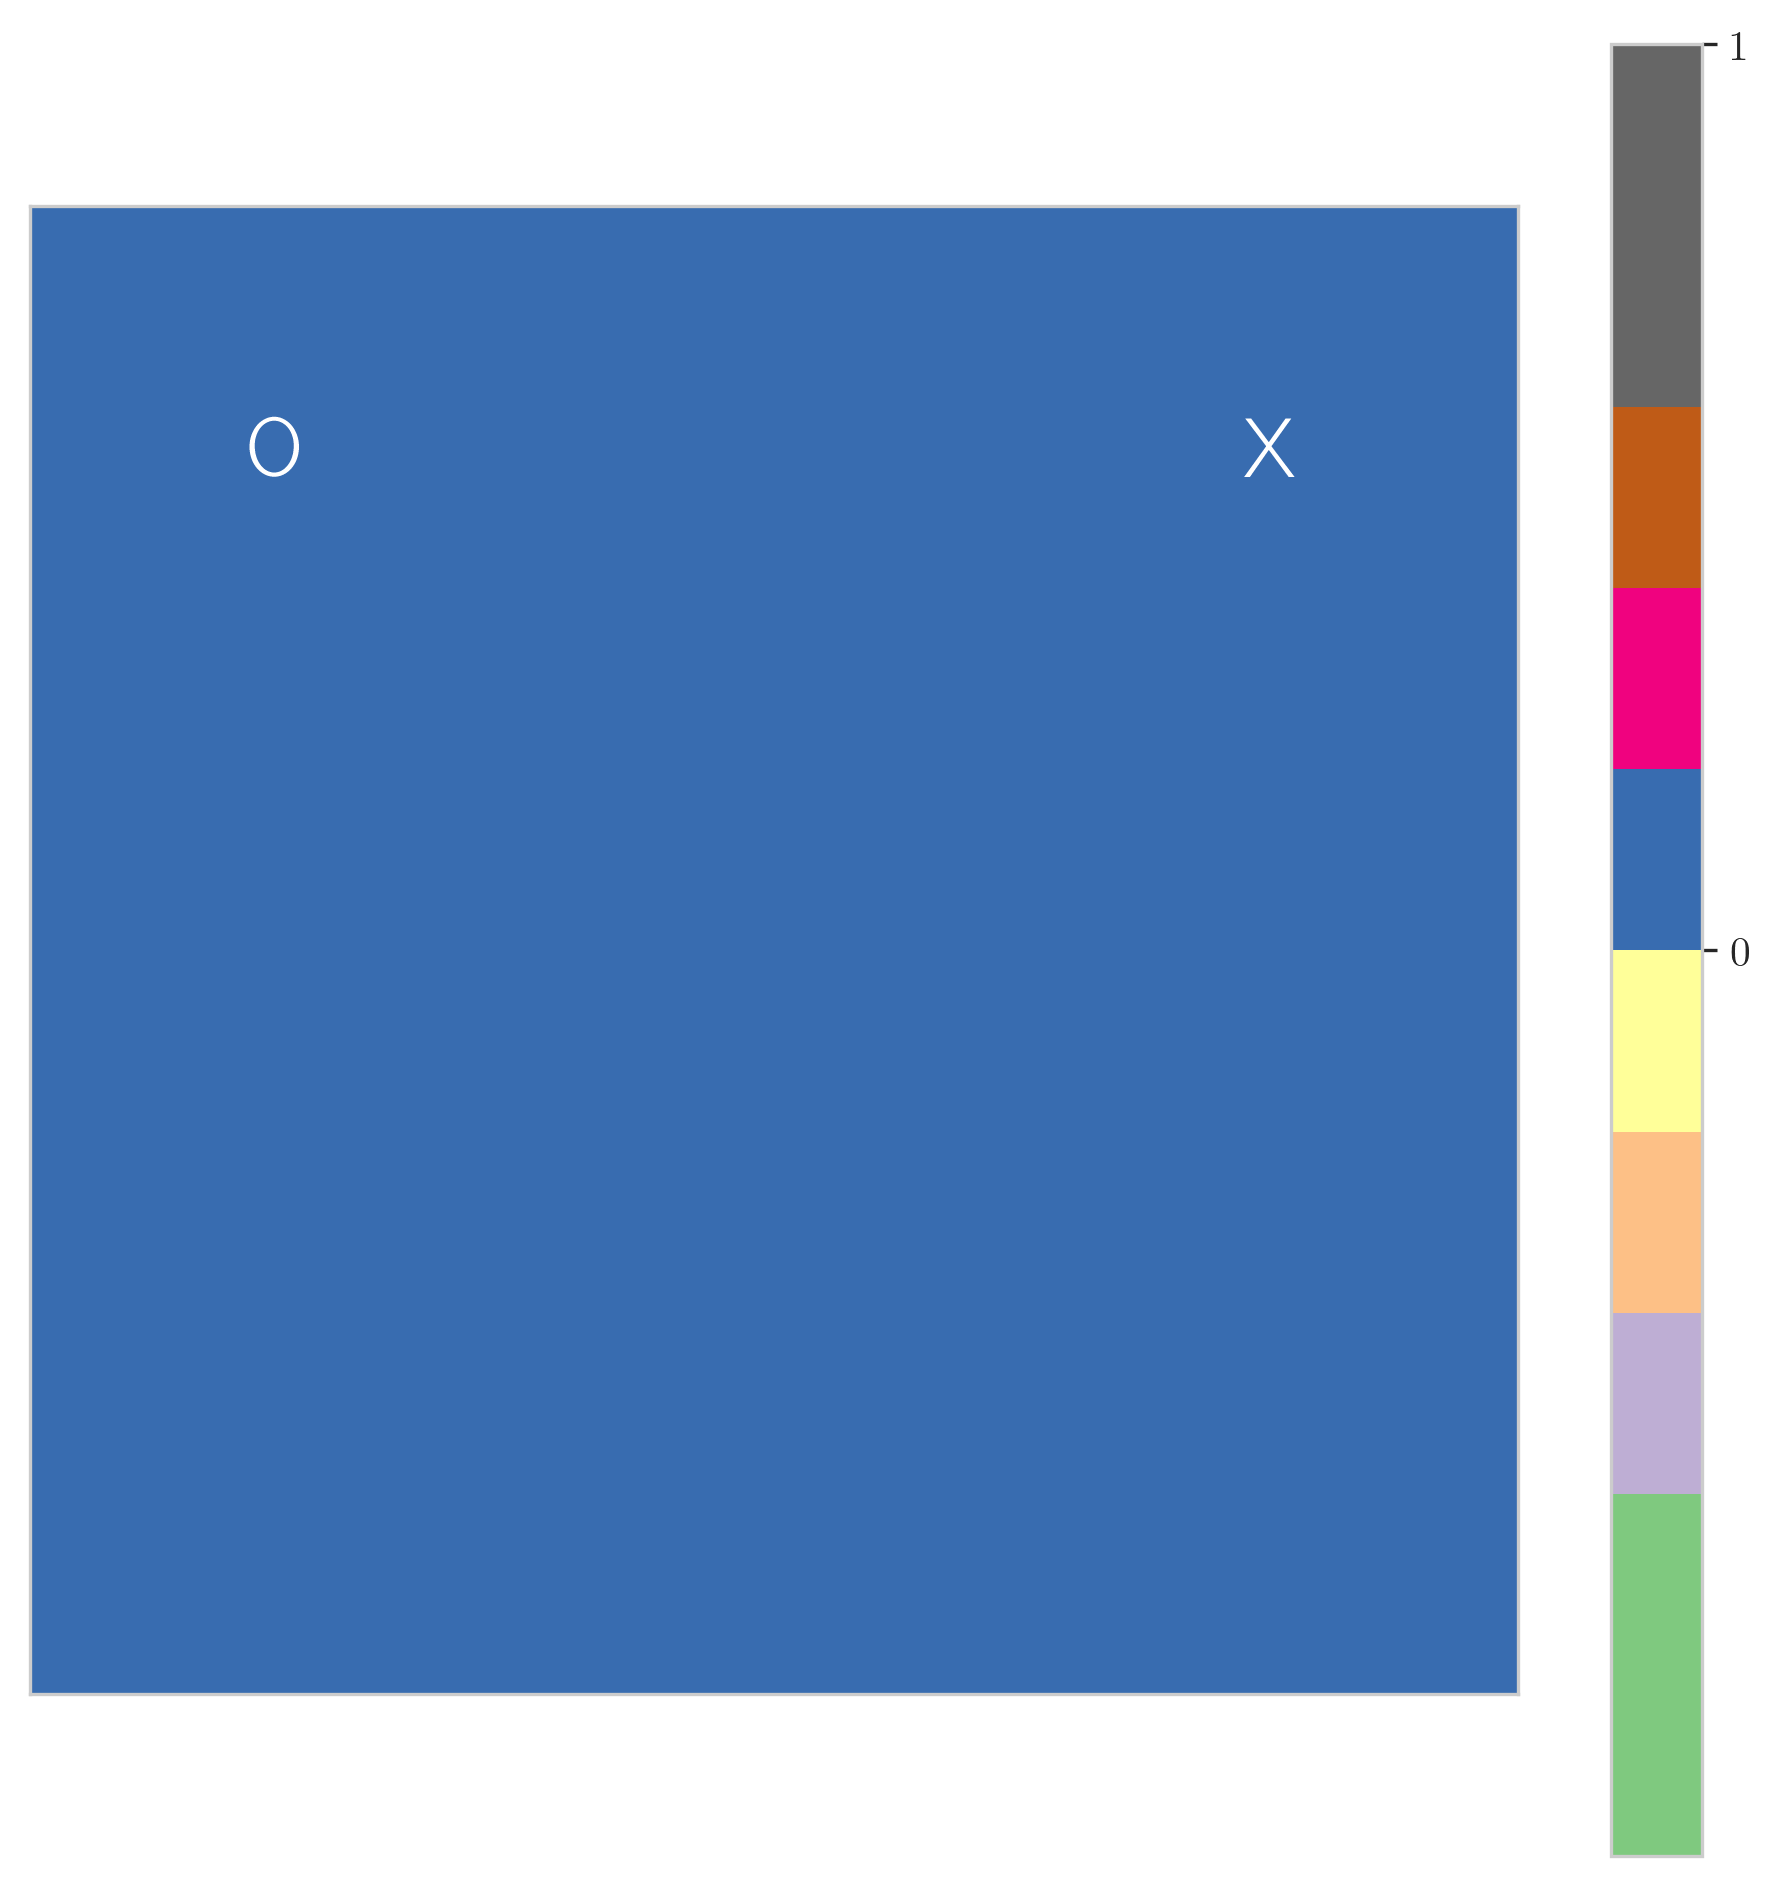

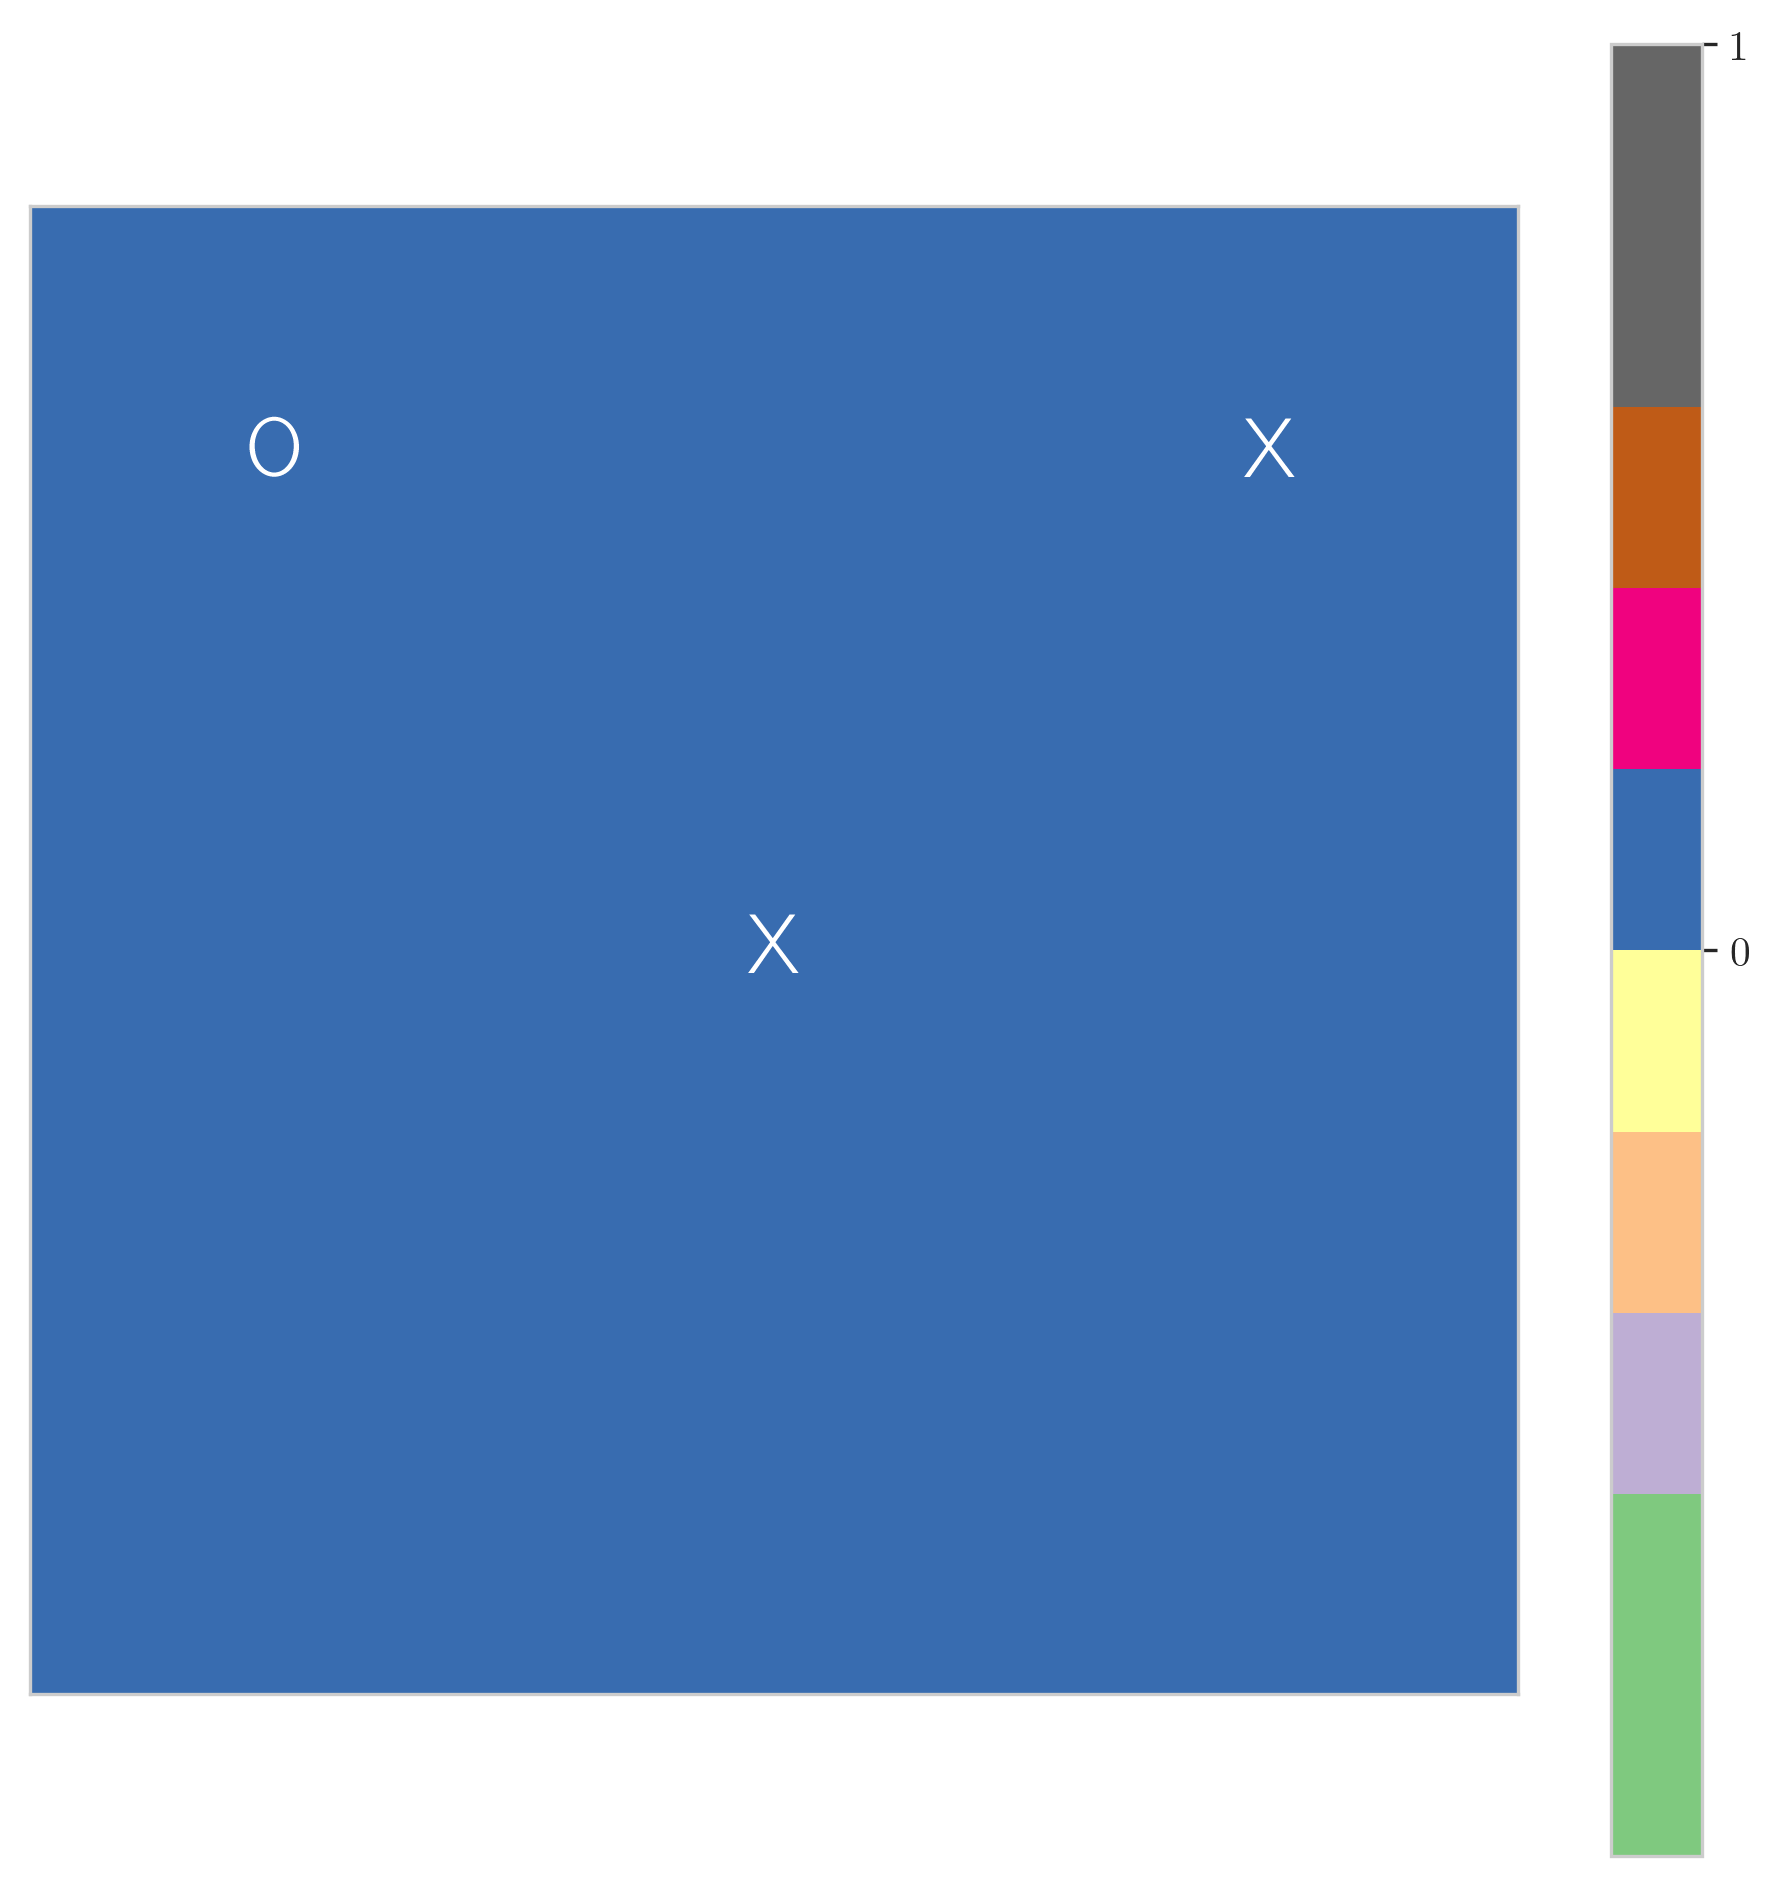

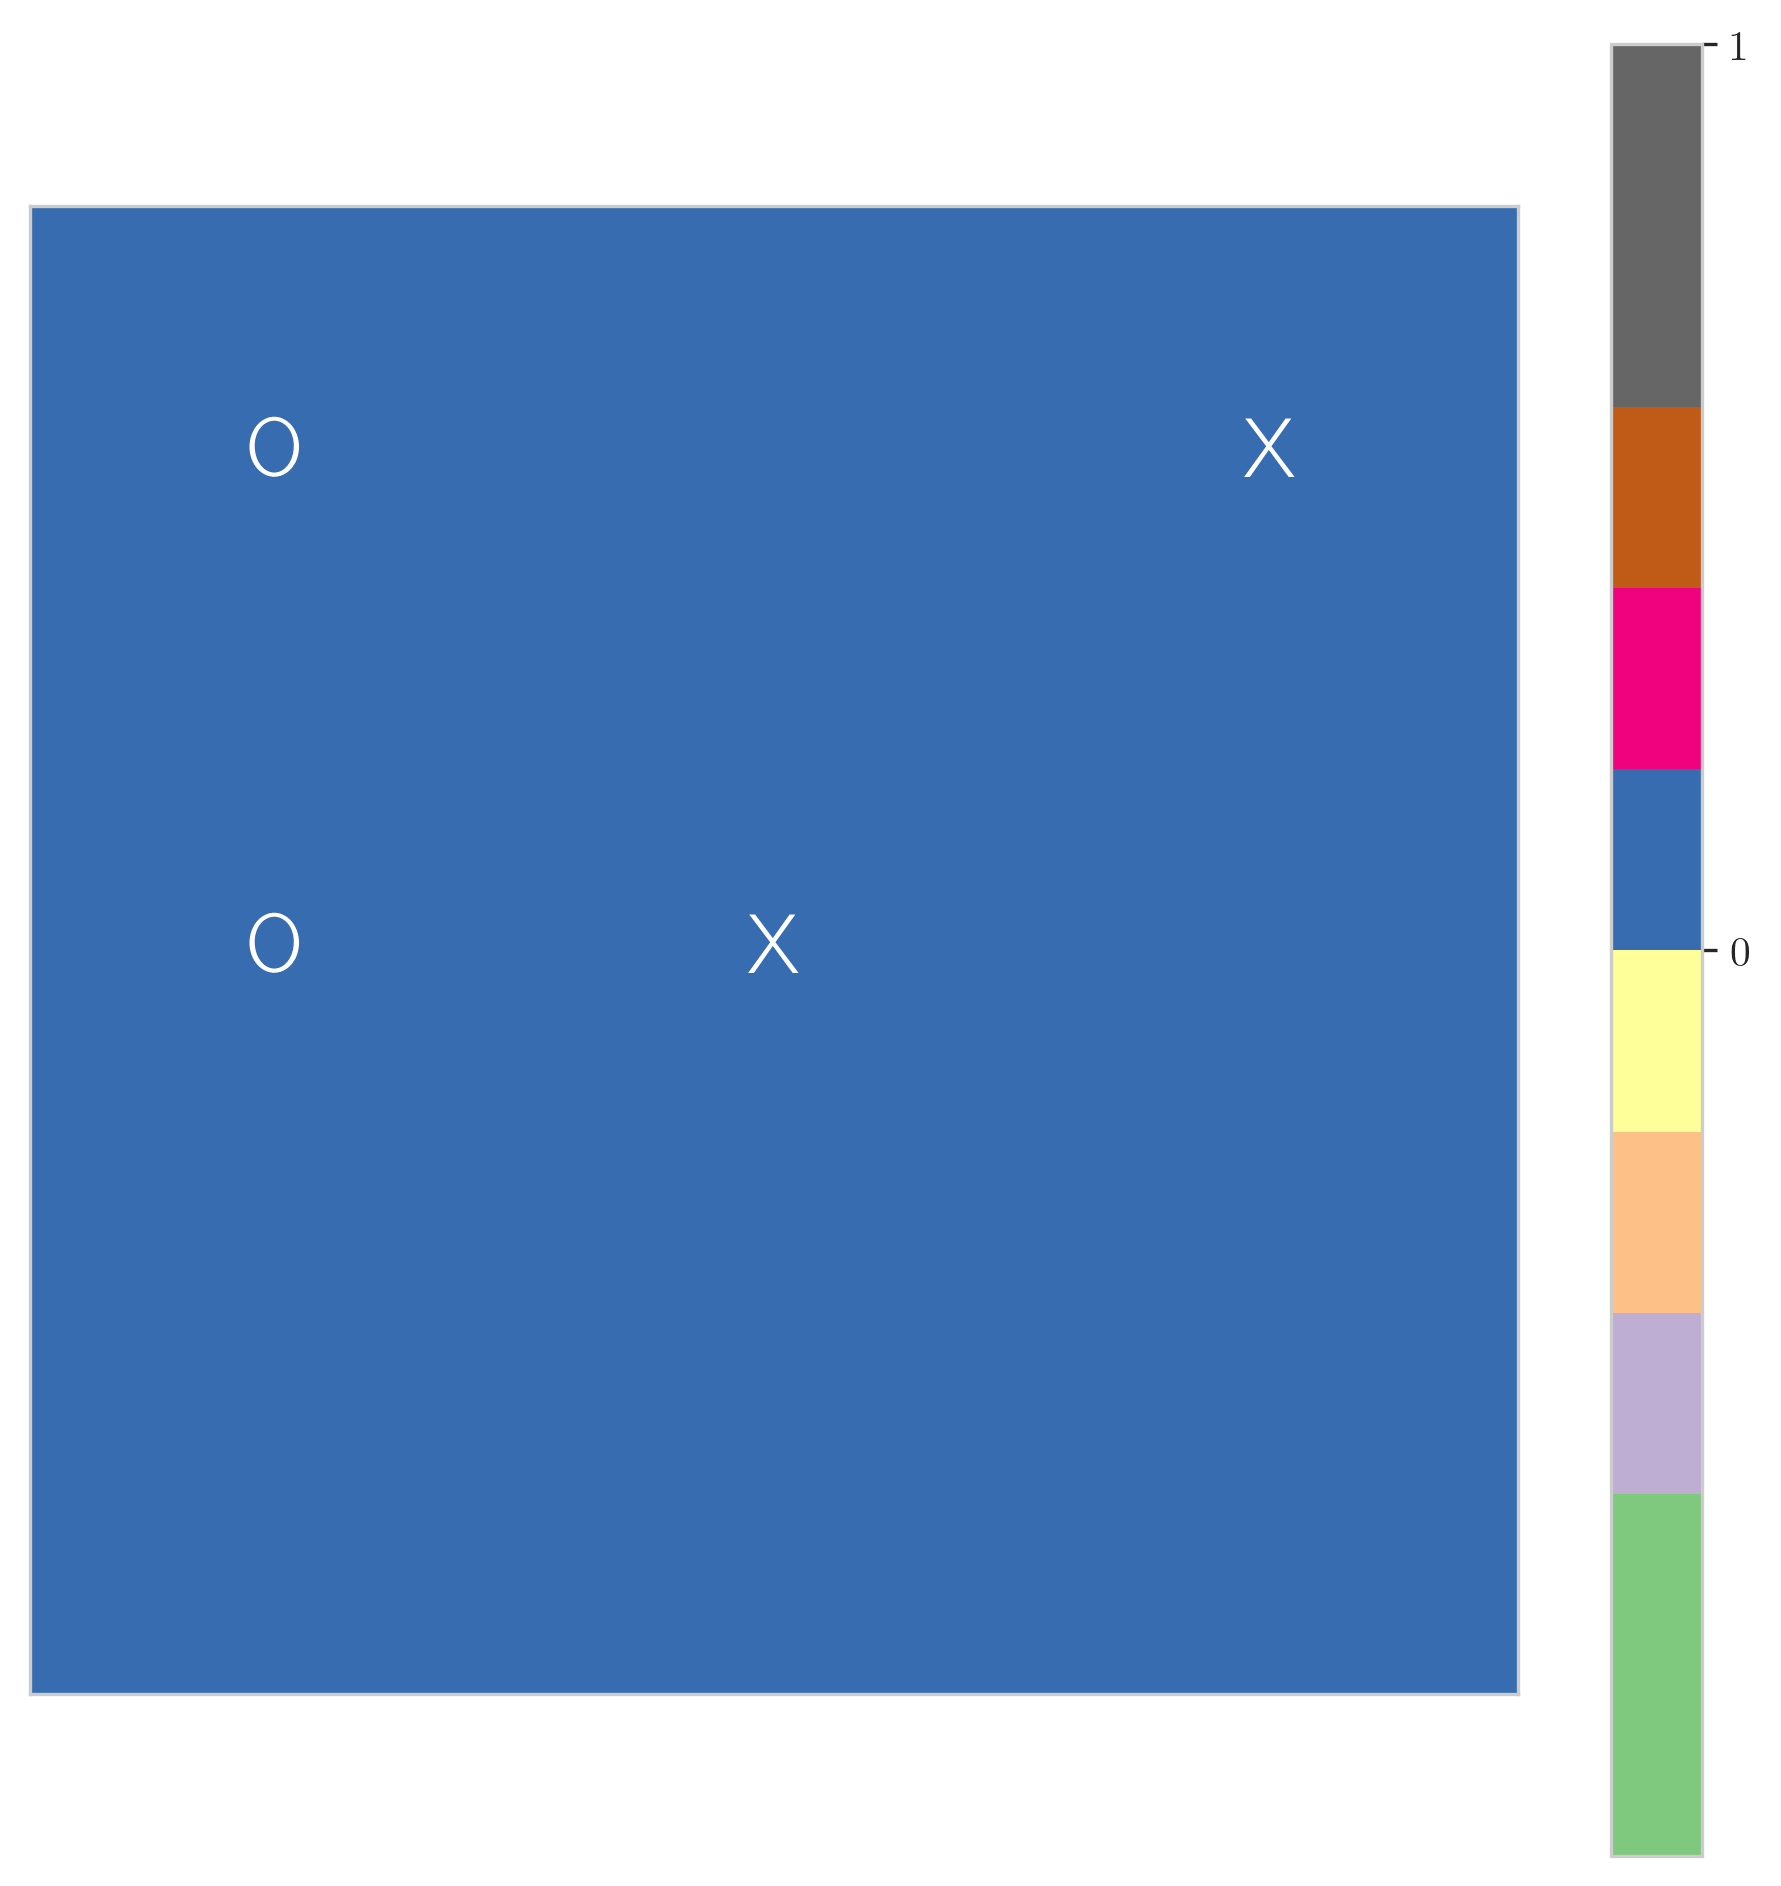

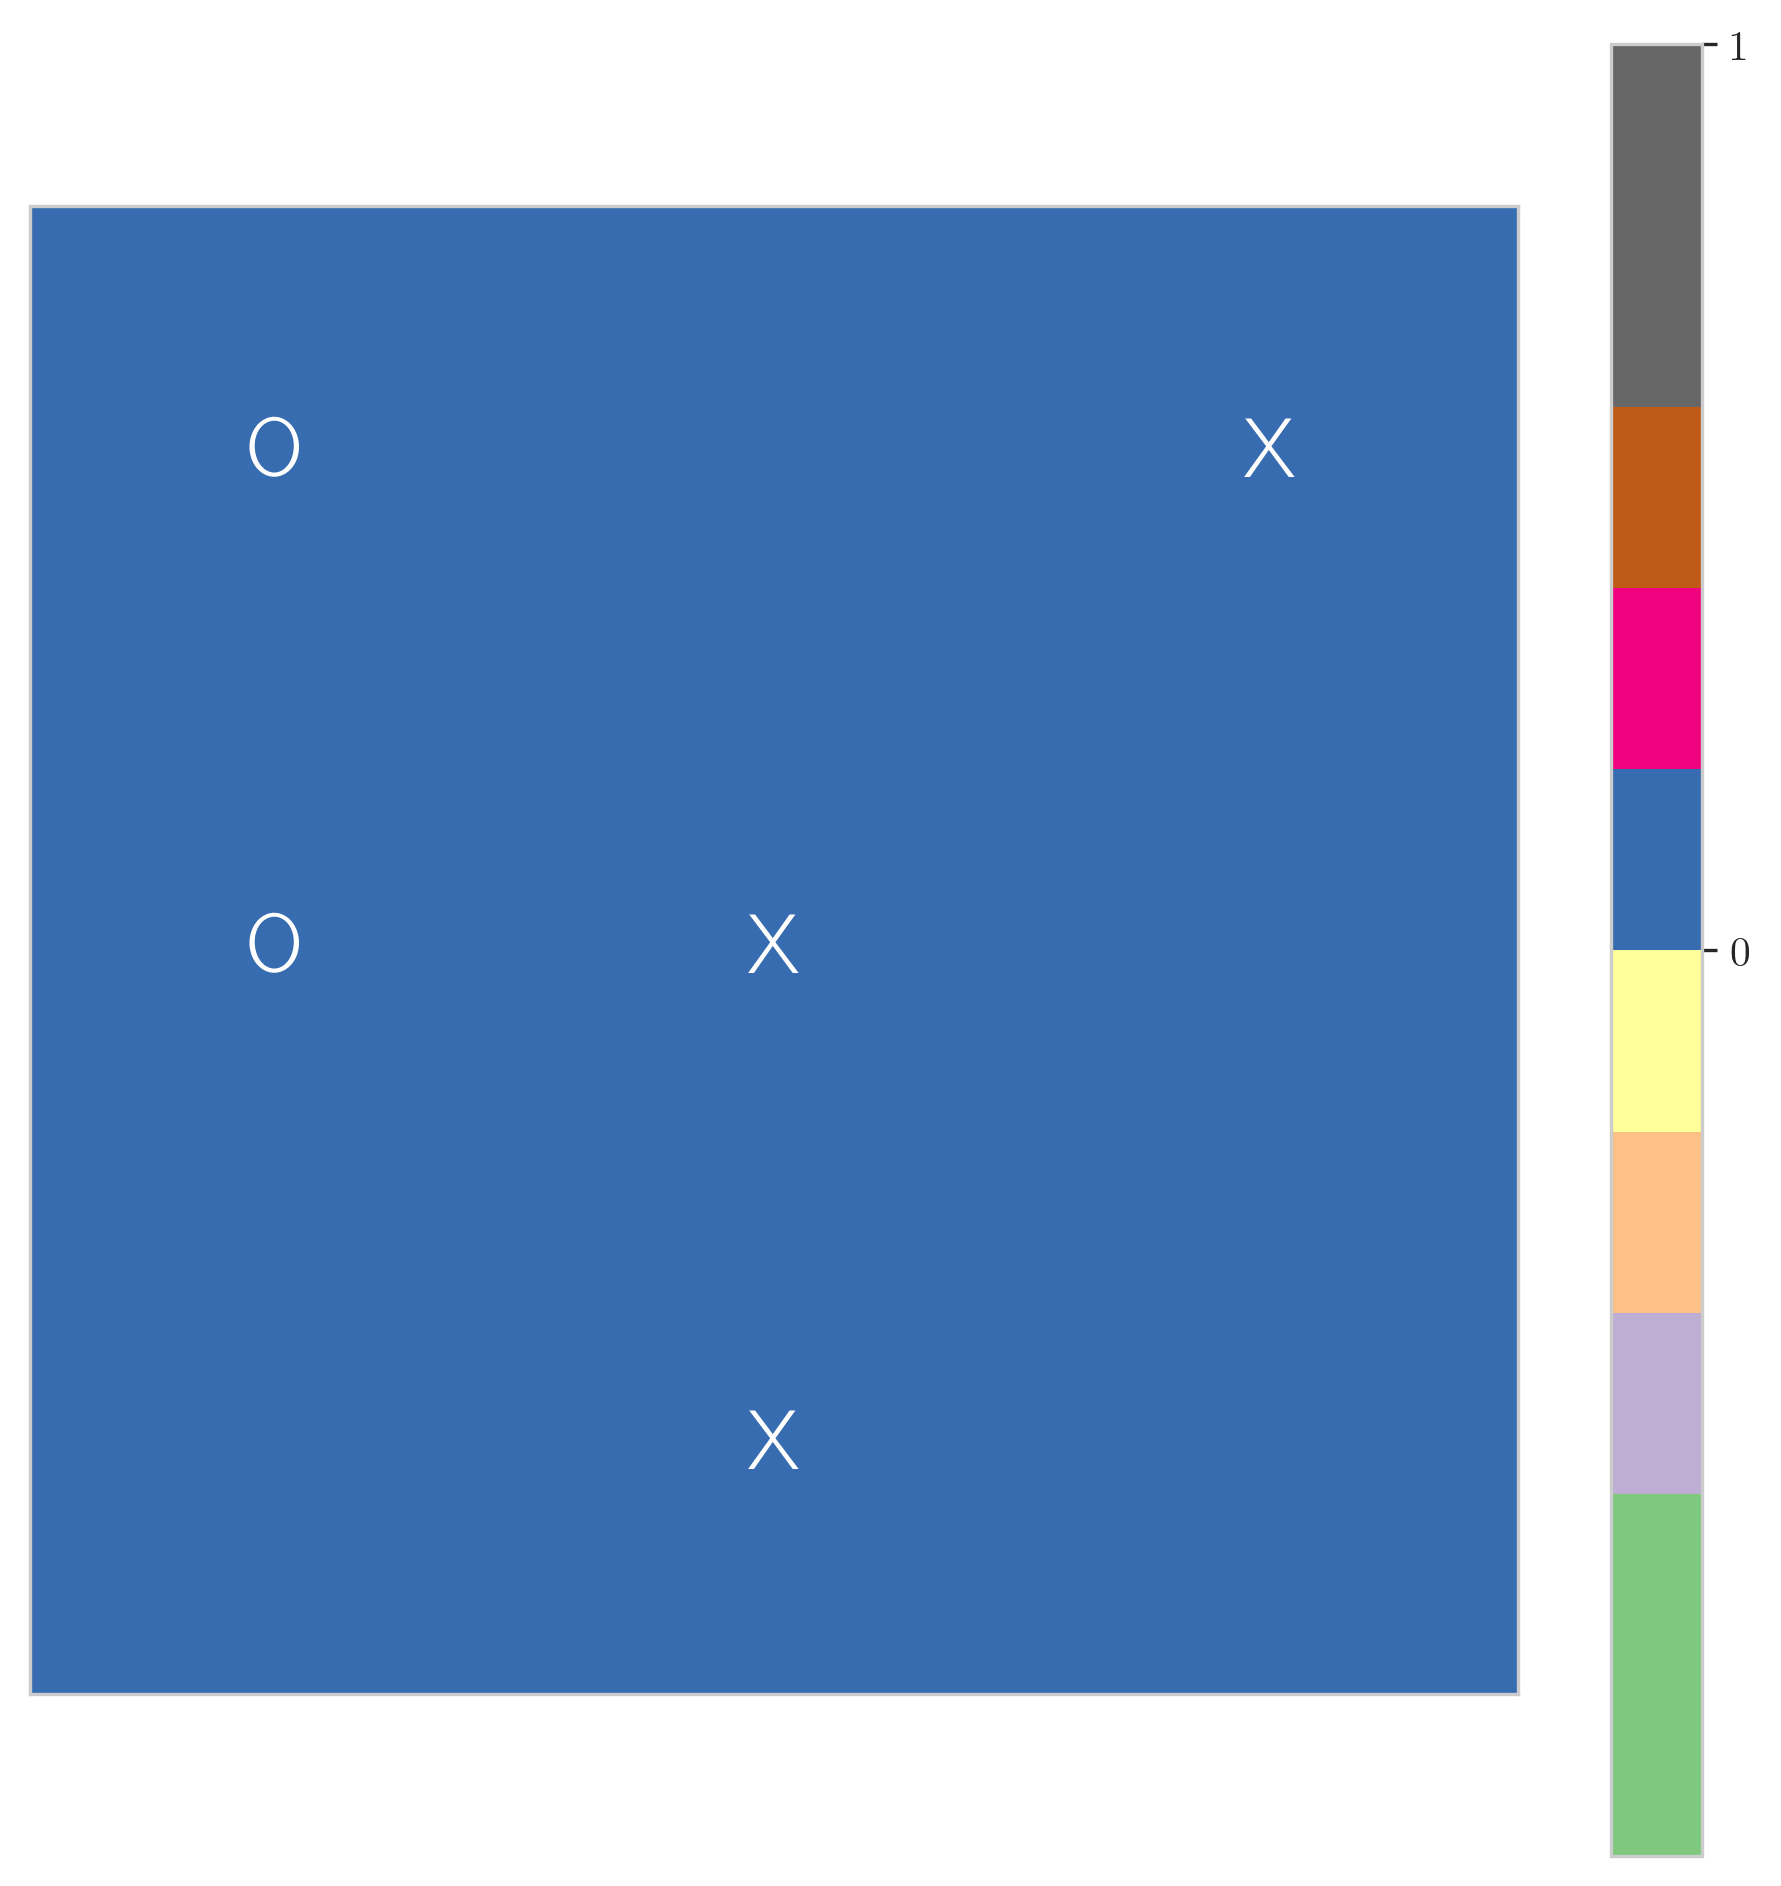

Нолики выиграли!


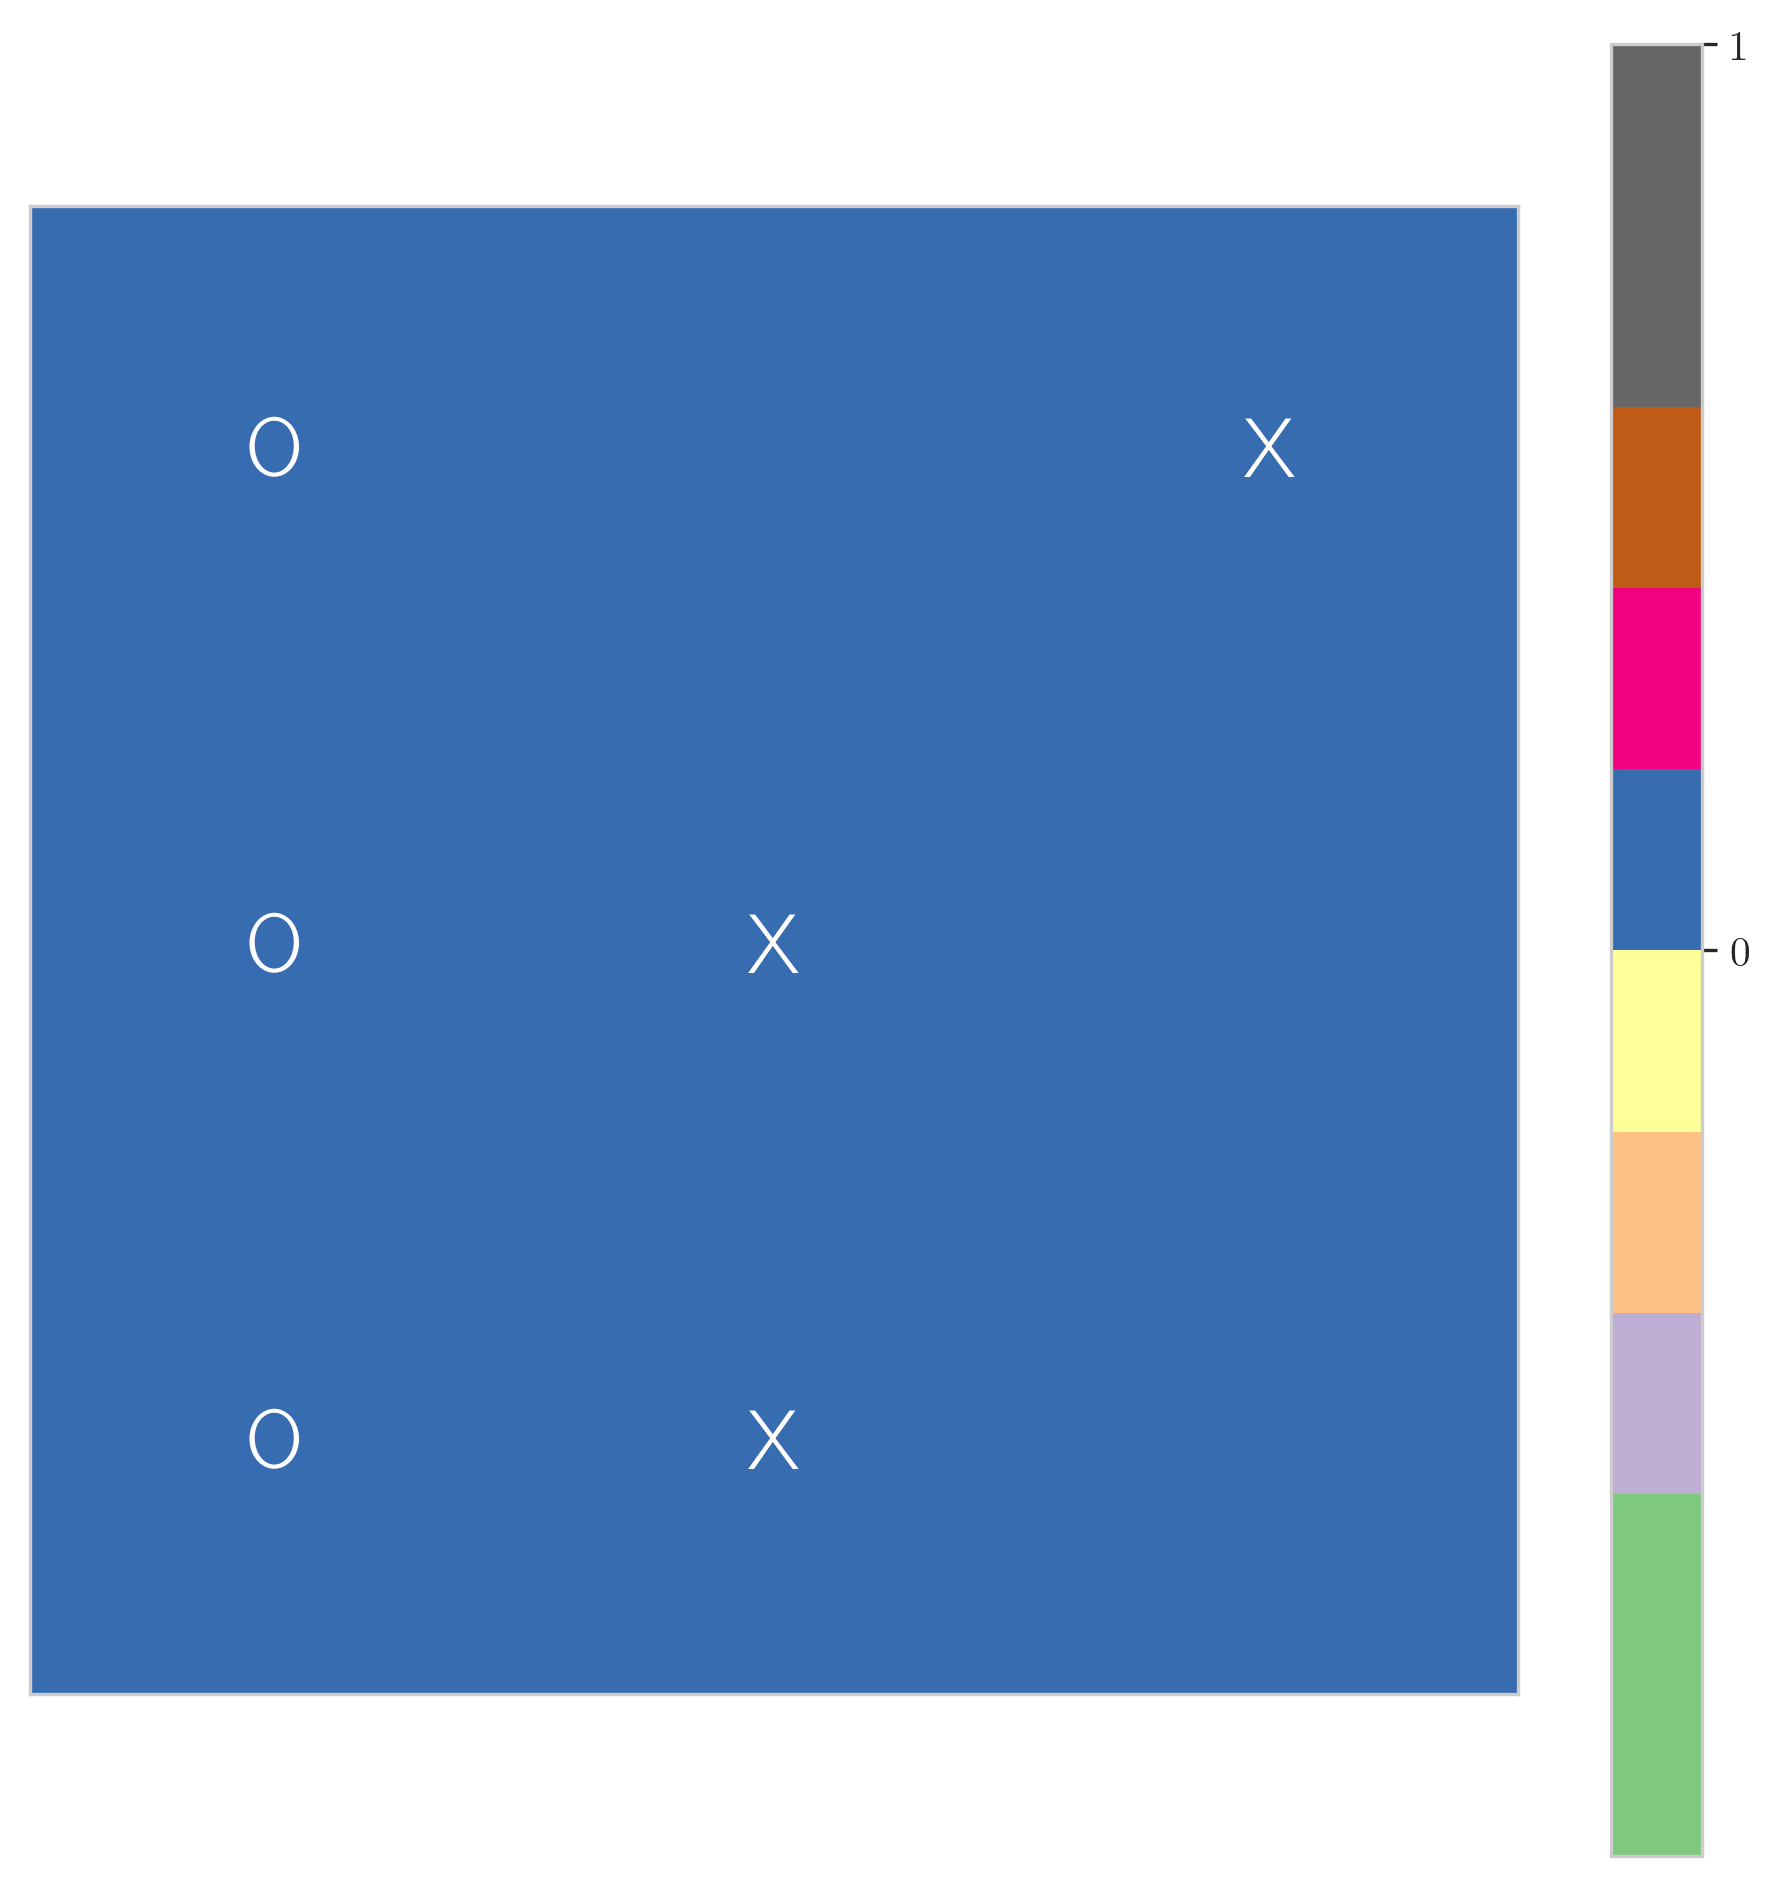

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

# Часть первая: крестики-нолики при помощи Q-обучения

## 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [7]:
class RandomStrategy():
    def __init__(self):
        self.Q = dict()
    
    def getActionGreedy(self, state, number_of_actions, exploration = 0.0):
        return np.random.randint(number_of_actions)

random_strat = RandomStrategy()

class Strategy():
    def __init__(self):
        self.Q = dict()
        
    def update_Q(self, state, action, number_of_actions, value):
        if not state in self.Q:
            self.Q[state] = np.zeros(number_of_actions)
        self.Q[state][action] = value
        
    def update_td(self, state, action, number_of_actions, state_next, alpha, gamma):
        if not state in self.Q:
            self.Q[state] = np.zeros(number_of_actions)
        next_q = np.max(self.Q[state_next])
        self.Q[state][action] = self.Q[state][action] + alpha * (gamma * next_q - self.Q[state][action])
    
    def getActionGreedy(self, state, number_of_actions, exploration = 0.0):
        if not state in self.Q:
            self.Q[state] = np.zeros(number_of_actions)
        
        if np.random.random() < exploration:
            return np.random.randint(number_of_actions)
        
        return np.argmax(self.Q[state])


In [8]:
def run_episode(env, x_strategy, y_strategy, exploration = 0.0):
    """Run one episode. Return all the game states and actions"""
    env.reset()
       
    states = []
    actions = []
    done = False
    
    while not done:
        board, possible_actions = env.getHash(), env.getEmptySpaces()
        states.append((board, len(possible_actions)))
        
        if env.curTurn == 1:
            action = x_strategy.getActionGreedy(board, len(possible_actions), exploration)
        else:
            action = y_strategy.getActionGreedy(board, len(possible_actions), exploration)
        actions.append(action)
            
        observation, reward, done, info = env.step(possible_actions[action])    
        
    return states, actions, reward

In [9]:
def test_strat(env, x_strategy, y_strategy, num_episodes):
    """Several episodes. Return the mean gain of X strategy"""
    rewards = 0
    
    for i in range(num_episodes):
        env.reset()
        done = False
    
        while not done:
            board, possible_actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                action = x_strategy.getActionGreedy(board, len(possible_actions))
            else:
                action = y_strategy.getActionGreedy(board, len(possible_actions))

            observation, reward, done, info = env.step(possible_actions[action])
            
        rewards += reward
        
    return rewards / num_episodes

In [10]:
def update_strategy(strategy, states, actions, reward, alpha, gamma):
    """Set the value for final step as a reward. Then go back through the episode and update estimations based on TD(0)"""
    
    state, number_of_actions =  states[-1]
    action = actions[-1]
    strategy.update_Q(state, action, number_of_actions, reward)
    
    for i in range(len(states)-2, -1, -1):
        state, number_of_actions = states[i]
        action = actions[i]
        state_next, number_of_actions_next = states[i+1]
        
        strategy.update_td(state, action, number_of_actions, state_next, alpha, gamma)

In [11]:
def learn_round(env, x_strat, y_strat, alpha=0.001, gamma=1.0, exploration=0.1):
    """Run one episode to the end and update both strategies based on the results"""
    states, actions, reward = run_episode(env, x_strat, y_strat, exploration)

    if not isinstance(x_strat, RandomStrategy):
        x_states =  states[::2]
        x_actions = actions[::2]
        update_strategy(x_strat, x_states, x_actions, reward, alpha, gamma)
    
    if not isinstance(y_strat, RandomStrategy):
        y_states = states[1::2]
        y_actions = actions[1::2]
        update_strategy(y_strat, y_states, y_actions, -reward, alpha, gamma)

In [12]:
def plot_results(rounds, x_results, y_results, title):
    plt.title(title)
    plt.plot(rounds, x_results, label='X')
    plt.plot(rounds, y_results, label='О')
    plt.legend(loc="center right")
    plt.show()

In [13]:
def learn_loop(env, x_strat, y_strat, alpha=0.01, gamma=1.0, exploration=0.1, num_episodes = 100000, test_episodes = 1000):
    x_results = []
    y_results = []
    rounds = np.unique(np.geomspace(1, num_episodes, num=30, dtype=int)-1)
    for i in tqdm.tqdm(range(num_episodes), position=0, leave=True):
        learn_round(env, x_strat, y_strat, alpha, gamma, exploration)
        if i in rounds:
            x_result = test_strat(env, x_strat, random_strat, test_episodes)
            y_result = -test_strat(env, random_strat, y_strat, test_episodes)
            x_results.append(x_result)
            y_results.append(y_result)
    
    return rounds, x_results, y_results

In [14]:
x_strategy_3 = Strategy()
y_strategy_3 = Strategy()
env_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
rounds_3, x_results_3, y_results_3 = learn_loop(env_3, x_strategy_3, y_strategy_3, alpha=0.001, exploration=0.3, gamma=0.9)


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:24<00:00, 1182.16it/s]


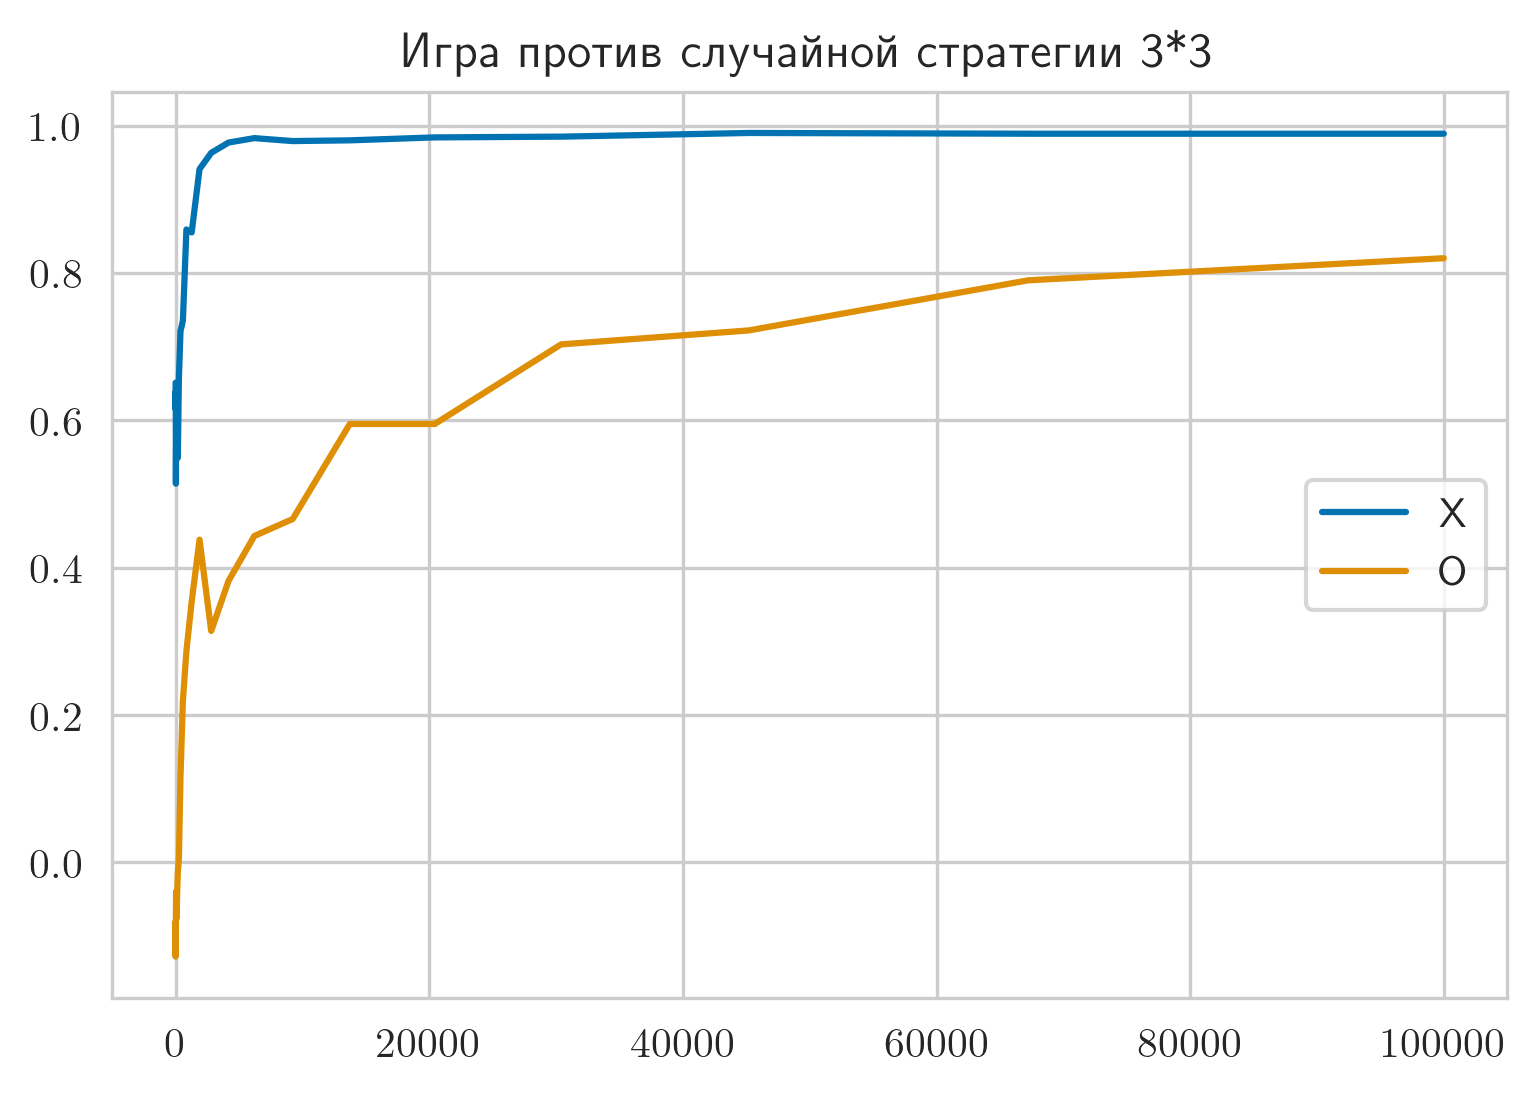

In [15]:
plot_results(rounds_3, x_results_3, y_results_3, 'Игра против случайной стратегии 3*3')

## 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5

In [30]:
x_strategy_4 = Strategy()
y_strategy_4 = Strategy()
env_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
rounds_4, x_results_4, y_results_4 = learn_loop(env_4, x_strategy_4, y_strategy_4, alpha=0.001, exploration=0.3, gamma=1, num_episodes = 5000000)


100%|█████████████████████████████████████████████████████████████████████| 5000000/5000000 [1:51:30<00:00, 747.35it/s]


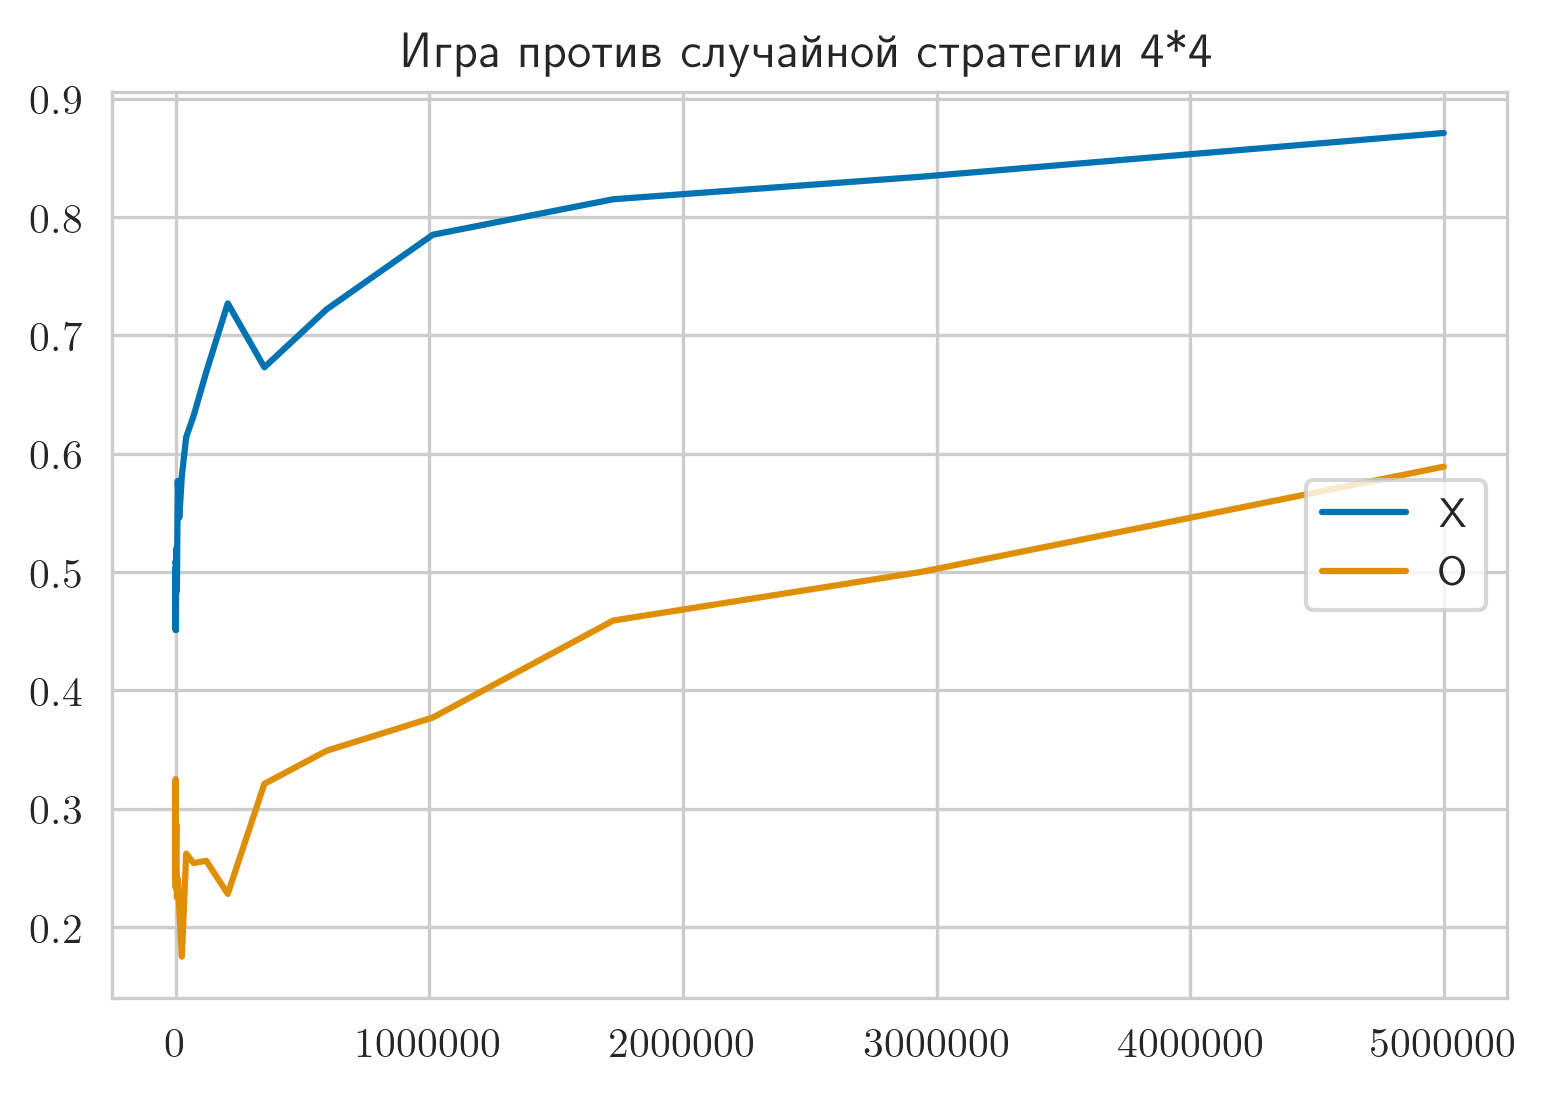

In [31]:
plot_results(rounds_4, x_results_4, y_results_4, 'Игра против случайной стратегии 4*4')

## 5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).


In [18]:
class RandomRolloutStrategy():
    def __init__(self, env, rollout_number = 50):
        self.env = env
        self.rollout_number = rollout_number
        
    def getActionGreedy(self, state, number_of_actions, exploration = 0.0):
        
        board, possible_actions = self.env.getHash(), self.env.getEmptySpaces()
        
        if number_of_actions != len(possible_actions):
            print(number_of_actions, len(possible_actions))
        
        rollouts = [self.rollout_for_action(a) for a in range(len(possible_actions))]
        
        if self.env.curTurn == 1:
            return np.argmax(rollouts)
        else:
            return np.argmin(rollouts)

    def rollout_for_action(self, action):
        rewards = 0
         
        for i in range(self.rollout_number):
            env_l = copy.deepcopy(self.env)
            board, possible_actions = env_l.getHash(), env_l.getEmptySpaces()
            observation, reward, done, _ = env_l.step(possible_actions[action])   
            while not done:
                board, possible_actions = env_l.getHash(), env_l.getEmptySpaces()
                a = np.random.randint(len(possible_actions))
                observation, reward, done, info = env_l.step(possible_actions[a])   
            rewards += reward
        
        return rewards / self.rollout_number
            
        

In [19]:
def test_strat_verb(env, x_strategy, y_strategy, num_episodes):
    """Several episodes. Return the mean gain of X strategy"""
    rewards = 0
    
    for i in tqdm.tqdm(range(num_episodes), position=0, leave=True):
        env.reset()
        done = False
    
        while not done:
            board, possible_actions = env.getHash(), env.getEmptySpaces()
            if env.curTurn == 1:
                action = x_strategy.getActionGreedy(board, len(possible_actions))
            else:
                action = y_strategy.getActionGreedy(board, len(possible_actions))

            observation, reward, done, info = env.step(possible_actions[action])
            
        rewards += reward
        
    return rewards / num_episodes

In [21]:
env_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
random_roll_strat_3_x = RandomRolloutStrategy(env_3, rollout_number = 100)
random_roll_strat_3_x_result = test_strat_verb(env_3, random_roll_strat_3_x, random_strat, 200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:40<00:00,  1.24it/s]


In [22]:
print(f'Random rollout 3-3 strat has score {random_roll_strat_3_x_result} for X')

Random rollout 3-3 strat has score 0.99 for X


In [23]:
env_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)
random_roll_strat_3_o = RandomRolloutStrategy(env_3, rollout_number = 100)
random_roll_strat_3_o_result = -test_strat_verb(env_3, random_strat, random_roll_strat_3_o, 200)
print(f'Random rollout 3-3 strat has score {random_roll_strat_3_o_result} for O')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:07<00:00,  1.57it/s]

Random rollout 3-3 strat has score 0.845 for O


In [24]:
env_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
random_roll_strat_4_x = RandomRolloutStrategy(env_4, rollout_number = 50)
random_roll_strat_4_x_result = test_strat_verb(env_4, random_roll_strat_4_x, random_strat, 500)
print(f'Random rollout 4-4 strat has score {random_roll_strat_4_x_result} for X')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [22:11<00:00,  2.66s/it]

Random rollout 4-4 strat has score 0.974 for X


In [33]:
random_roll_strat_4_o = RandomRolloutStrategy(env_4, rollout_number = 50)
random_roll_strat_4_o_result = test_strat_verb(env_4, random_strat,random_roll_strat_4_o, 500)
print(f'Random rollout 4-4 strat has score {random_roll_strat_4_o_result} for O')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [19:12<00:00,  2.31s/it]

Random rollout 4-4 strat has score -0.904 for O


In [25]:
x = [1, 3, 5, 10, 20, 50]
results = []
for i in x:
    env_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
    roll_strat_4 = RandomRolloutStrategy(env_4, rollout_number = i)
    result = test_strat_verb(env_4, roll_strat_4, random_strat, 100)
    results.append(result)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.59s/it]


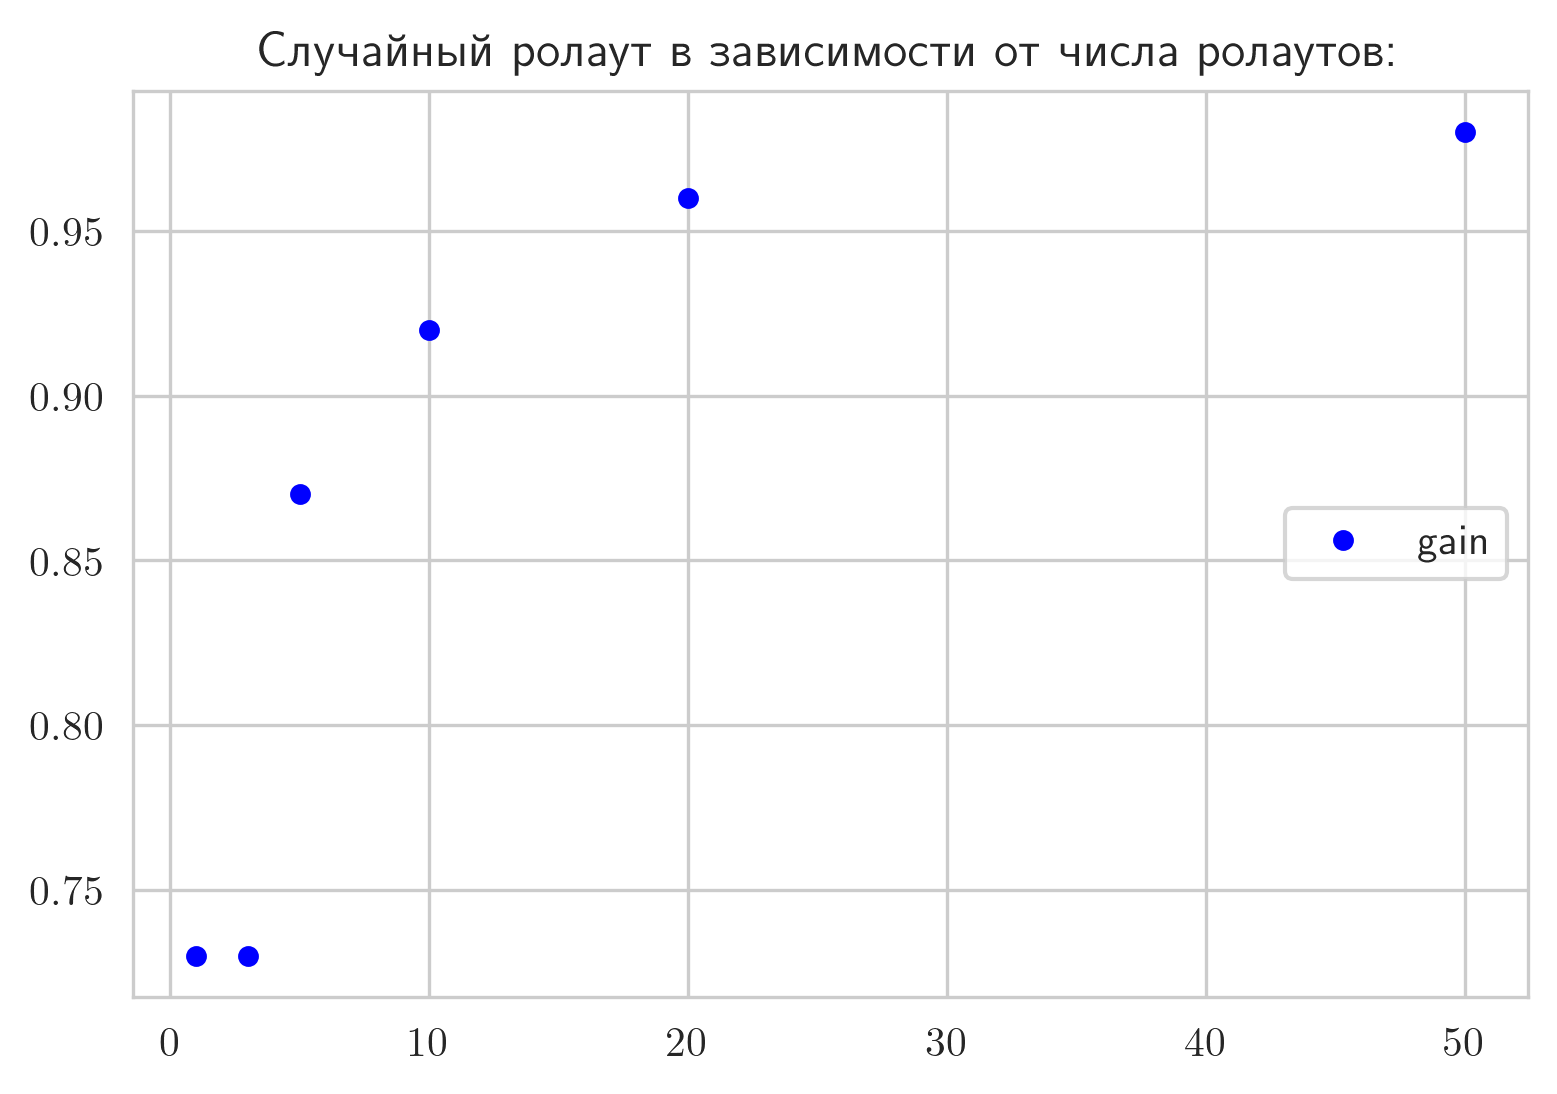

In [26]:
plt.title('Случайный ролаут в зависимости от числа ролаутов:')
plt.plot(x, results, 'bo', label='gain', markersize=4)
plt.legend(loc="center right")
plt.show()

In [27]:
class StategicRolloutStrategy():
    def __init__(self, env, x_strat, y_strat, rollout_number = 50):
        self.env = env
        self.rollout_number = rollout_number
        self.x_strat = x_strat
        self.y_strat = y_strat
        
    def getActionGreedy(self, state, number_of_actions, exploration = 0.0):
        
        board, possible_actions = self.env.getHash(), self.env.getEmptySpaces()
        
        if number_of_actions != len(possible_actions):
            print(number_of_actions, len(possible_actions))
        
        rollouts = [self.rollout_for_action(a) for a in range(len(possible_actions))]
        
        if self.env.curTurn == 1:
            return np.argmax(rollouts)
        else:
            return np.argmin(rollouts)

    def rollout_for_action(self, action):
        rewards = 0
         
        for i in range(self.rollout_number):
            env_l = copy.deepcopy(self.env)
            board, possible_actions = env_l.getHash(), env_l.getEmptySpaces()
            observation, reward, done, _ = env_l.step(possible_actions[action])   
            while not done:
                board, possible_actions = env_l.getHash(), env_l.getEmptySpaces()
                if env_l.curTurn == 1:
                    a = self.x_strat.getActionGreedy(board, len(possible_actions))
                else:
                    a = self.y_strat.getActionGreedy(board, len(possible_actions))
                
                observation, reward, done, info = env_l.step(possible_actions[a])   
            rewards += reward
        
        return rewards / self.rollout_number
            

In [34]:
env_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)
strat_roll_strat_4 = StategicRolloutStrategy(env_4, x_strategy_4, random_strat,rollout_number = 50)
strat_roll_strat_4_result = test_strat_verb(env_4, strat_roll_strat_4, random_strat, 500)
print(f'Rollout 4-4 based on previois strat has score {strat_roll_strat_4_result} for X')

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [15:22<00:00,  1.85s/it]

Rollout 4-4 based on previois strat has score 0.966 for X


# Сравним полученные стратегии при игре против случайной


In [36]:
print(f'Стратегия с Q-обучением получает {x_results_4[-1]}')
print(f'Стратегия со случайным ролаутом получает {random_roll_strat_4_x_result}')
print(f'Стратегия со ролаутом основанная на Q-стратегии получает {strat_roll_strat_4_result}')

Стратегия с Q-обучением получает 0.871
Стратегия со случайным ролаутом получает 0.974
Стратегия со ролаутом основанная на Q-стратегии получает 0.966


## Выводы:
1. Стратегия, основанная на Q-обучении даёт неплохие результаты, но долго учится. Текущая стратегия не обучена до конца
2. Стратегия со случайным ролаутом показывает отличный результат.
3. Добавление ролаута к нашей Q-стратегии ощутимо её улучшило.